## Project introduction
### You can read the proposal for detailed explanation of the project
### To be brief, the goal of this project is to develop a predictive model that forecasts stock returns in the Chinese stock market using historical data in 2021.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
import statsmodels.api as sm

## Data Processing
### Use the data processed before and construct some new qualitative variables. Read the proposal if require detailed explanation

### Use China Securities Index 300 etf  stock data in China A-shore market

In [ ]:
from stock_centre import *
hq = Stock_Data_Centre()

code_ls = hq.get_index_components(index_code='000300.SH', date='2022-01-01')

In [ ]:
code_ls = code_ls['con_code'].unique().tolist()

In [ ]:
temp1 = pd.read_feather('stockdata.fea')

In [ ]:
temp2 = pd.read_feather(f'qualitative_factor_201801_202404.feather')

In [ ]:
df = temp1.merge(temp2, on=['code','date'], how='left')
df = df[df['code'].isin(code_ls)]
del temp1, temp2

In [ ]:
df

,index,date,code,IntroClain,CleverMoneyV1,CleverMoneyV2,CORAV1,CORAV2,InDayVol,EndAmountPortion,...,HVRealizedSkew,IDhf,RTVV1,VCVV1,ret,ConsecutiveLimitIndicator,LiquidityIndicator,MorningAfternoonVolatilityIndicator,JumpIndicator,MarketCapIndicator
0,2646913,2021-01-04,000001.SZ,-2.307922e-08,1.001415,0.998645,0.388472,0.403585,0.771950,0.067540,...,-0.406428,-0.062500,0.000020,0.771950,-0.017704,0,1,1,1,1
1,2646914,2021-01-04,000002.SZ,-6.410019e-25,1.001249,0.998955,0.315000,0.287930,0.653615,0.069361,...,-0.065703,-0.016667,0.000007,0.653615,0.000850,0,1,1,1,1
46,2646959,2021-01-04,000063.SZ,-1.572439e-07,1.004285,0.993326,0.631008,0.418536,1.020093,0.133937,...,1.112980,-0.020833,0.000036,1.020093,0.023990,0,1,0,1,1
48,2646961,2021-01-04,000066.SZ,-2.987916e-21,0.998321,1.015908,0.378624,0.192933,1.785623,0.063742,...,0.411036,-0.020833,0.000171,1.785623,0.020562,0,1,1,1,1
50,2646963,2021-01-04,000069.SZ,-9.805961e-07,1.001192,0.998321,0.033850,-0.044665,1.003282,0.080880,...,-0.060512,-0.025000,0.000015,1.003282,-0.003101,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408270,6055183,2023-12-29,688363.SH,-4.994732e-06,0.997821,1.013145,0.264262,0.305864,1.182238,0.110618,...,0.343820,-0.066667,0.000019,1.182238,-0.011713,0,1,1,1,0
3408299,6055212,2023-12-29,688396.SH,-3.515678e-06,0.998415,1.004779,0.119409,0.130016,0.688588,0.089914,...,0.636949,0.050000,0.000011,0.688588,-0.028737,0,1,1,1,0
3408387,6055300,2023-12-29,688561.SH,-7.929759e-07,0.997959,1.006442,0.250577,0.444521,1.018495,0.060102,...,-0.670061,-0.025000,0.000023,1.018495,-0.033881,0,1,1,1,0
3408418,6055331,2023-12-29,688599.SH,-2.737843e-13,0.999824,1.001942,0.265656,0.273097,1.209220,0.072041,...,-0.220050,-0.008333,0.000090,1.209220,-0.027671,0,1,1,1,0


In [ ]:
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

In [ ]:
b_ls = ['JumpIndicator', 'MorningAfternoonVolatilityIndicator', 'MarketCapIndicator','LiquidityIndicator','ConsecutiveLimitIndicator']

In [ ]:
q_ls = ['CleverMoneyV1', 'CORAV1', 'InDayVol', 'EndAmountPortion', 'ACMA', 'VSPlow', 'IntradayExtremeReturn', 'IndayRsi', 'IndayHighLow', 'EarnVolumeRatio', 'VolRebalancePriceV1', 'VSPAPP', 'CDPPV1', 'HVRealizedSkew']

In [ ]:
fea_ls = q_ls+b_ls

### Monthly aggregation: group by month and stock code, getting the mean value of certain varaible of a certain stock in a month. For predictive value, we calculate the sum of return in the month.

In [ ]:
temp1_df = df[fea_ls+['month', 'code']].groupby(['month', 'code']).mean().reset_index()
temp2_df = df[['month', 'code', 'ret']].groupby(['month', 'code']).sum().reset_index()

### Calculation of qualitative variables:
### Note that we have calculated the mean value of the original qualitative varaibles, so need new thresholds
### Divide MarketCapIndicator into three intervals and assigns values 3, 2, or 1 based on the conditions: x>0.7--3, 0.3<x<0.7--2, x<0.3--1
### JumpIndicator, MorningAfternoonVolatilityIndicator, LiquidityIndicator: 0.7 as threshold, >0.7--1, <0.7--0
### ConsecutiveLimitIndicator: 0 as threshold, >0--1. Meaning: if exist consecutive limit price in one month, the variable is assigned 1

In [ ]:
for fea in ['MarketCapIndicator']:
    temp1_df[fea] = (temp1_df[fea]>0.7)*3 + (temp1_df[fea]<=0.7)*2*(temp1_df[fea]>=0.3) +1*(temp1_df[fea]<0.3)
temp1_df['JumpIndicator_ogn'] = temp1_df['JumpIndicator']
temp1_df['JumpIndicator'] = (temp1_df['JumpIndicator']>0.7)*1
temp1_df['MorningAfternoonVolatilityIndicator'] = (temp1_df['MorningAfternoonVolatilityIndicator']>0.7)*1
temp1_df['LiquidityIndicator'] = (temp1_df['LiquidityIndicator']>0.7)*1 + (temp1_df['LiquidityIndicator']<=0.7)*0
temp1_df['ConsecutiveLimitIndicator'] = (temp1_df['ConsecutiveLimitIndicator']>0)*1

### The predictive value ret is calculated as the return of the stock in one month minus the average return of all stocks in that month

In [ ]:
temp2_df['ret_mean'] = temp2_df.groupby('month')['ret'].transform('mean')

In [ ]:
temp2_df['ret'] =temp2_df['ret'] - temp2_df['ret_mean']

In [ ]:
df = temp1_df.merge(temp2_df, on=['code', 'month'], how='inner')
del temp1_df, temp2_df

### Use one year data, 2021 and 300 stocks from China Securities Index 300 etf

In [ ]:
df = df[df['month']<'2022-01-01']
df['month_factor'] = df['month'].dt.month

## Statistics of the features
### Qualitative variables: boxplot

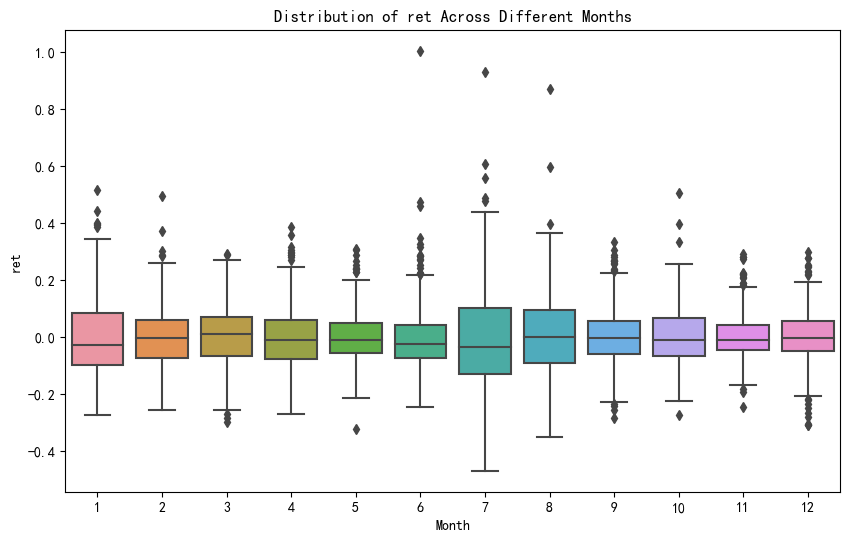

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='month_factor', y='ret')
plt.title('Distribution of ret Across Different Months')
plt.xlabel('Month')
plt.ylabel('ret')
plt.show()

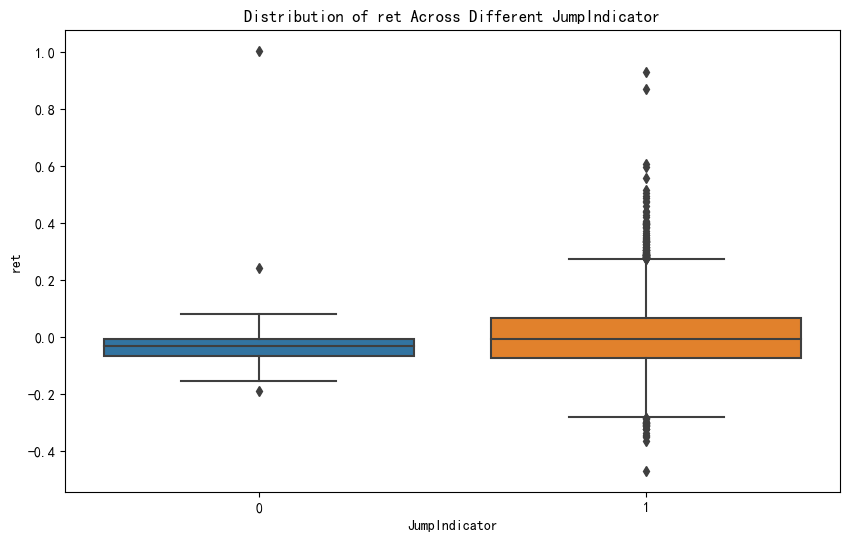

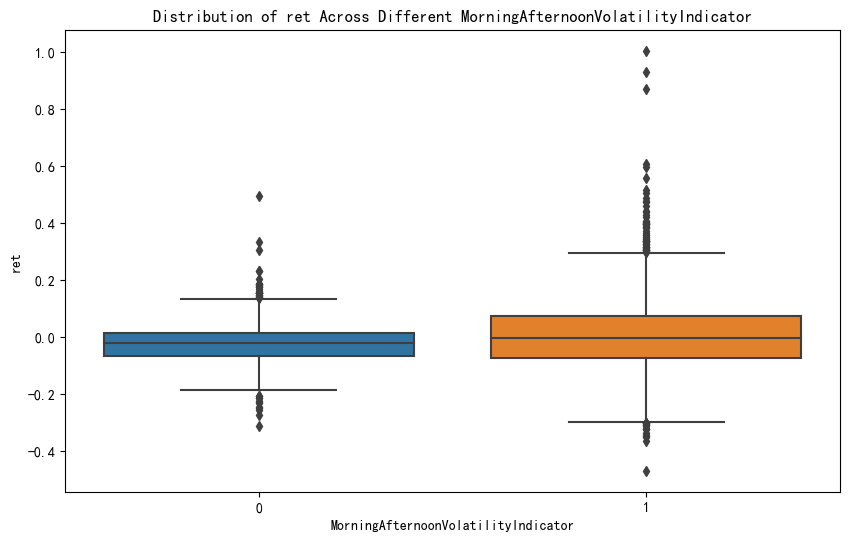

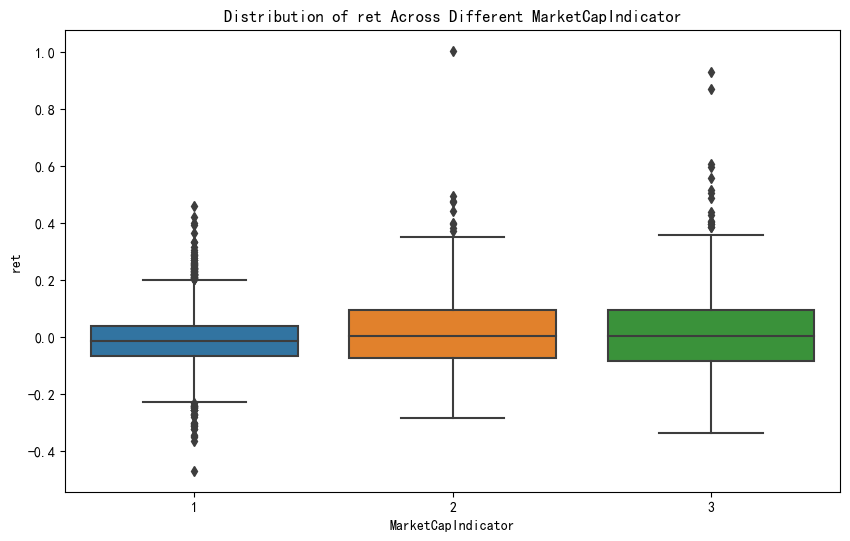

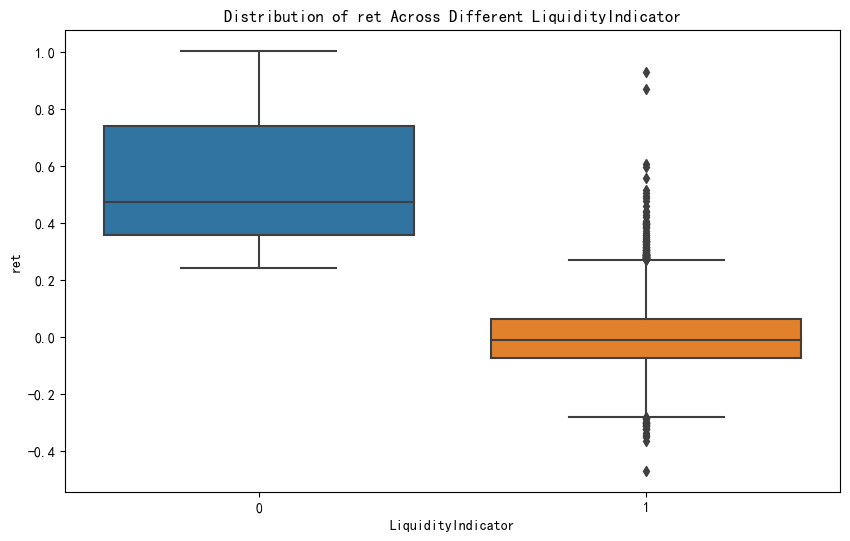

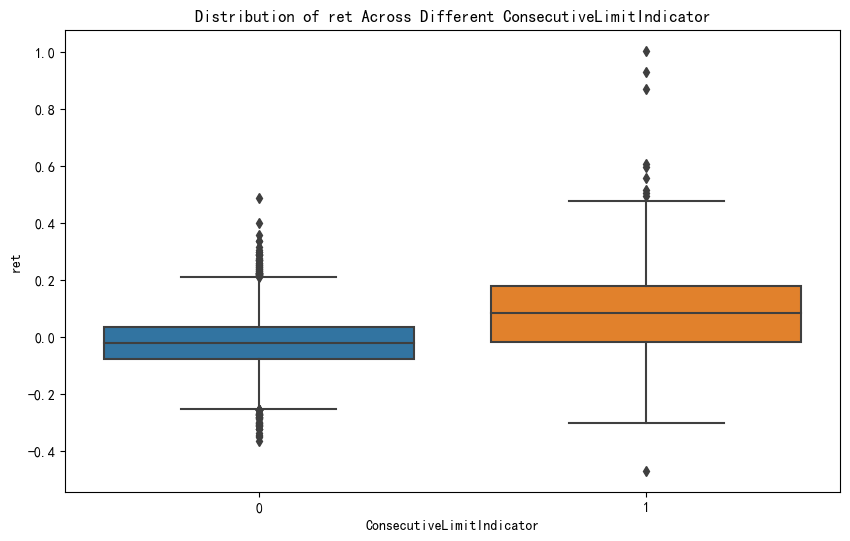

In [ ]:
for fea in b_ls:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=fea, y='ret')
    plt.title(f'Distribution of ret Across Different {fea}')
    plt.xlabel(f'{fea}')
    plt.ylabel('ret')
    plt.show()

### Quantitative Variables: Scatter Plot. We can choose some good scatter plots to report, like IndayRsi
### Based on the shape of scatter plot, we can do alters in the calculation of variables. If the shape of the scatter plot is similar to a log function, then we can do log(x) and use it as new variable. Also, if the shape is similar to a square function curve, we can do x^2 and use it as new variable.

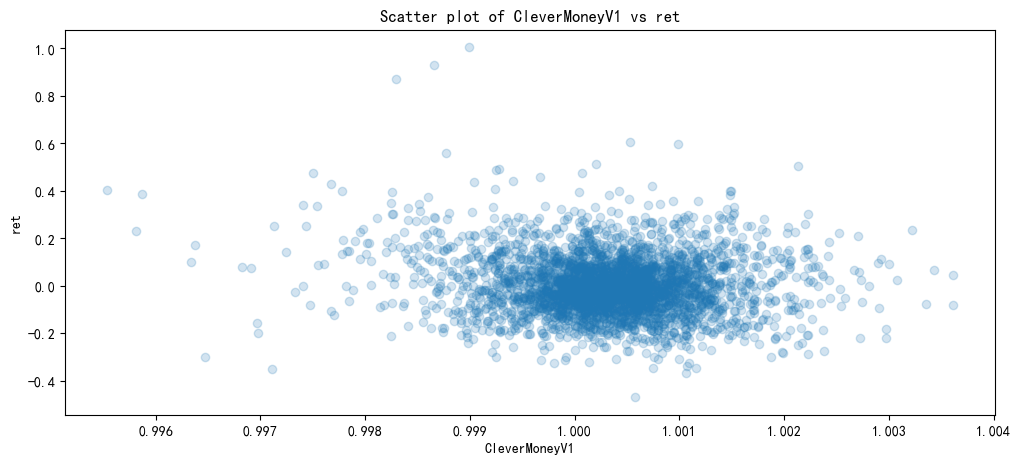

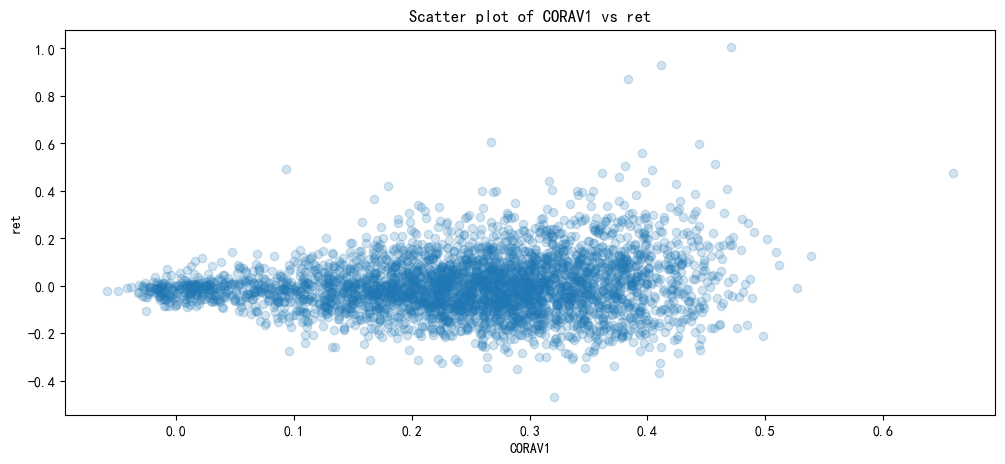

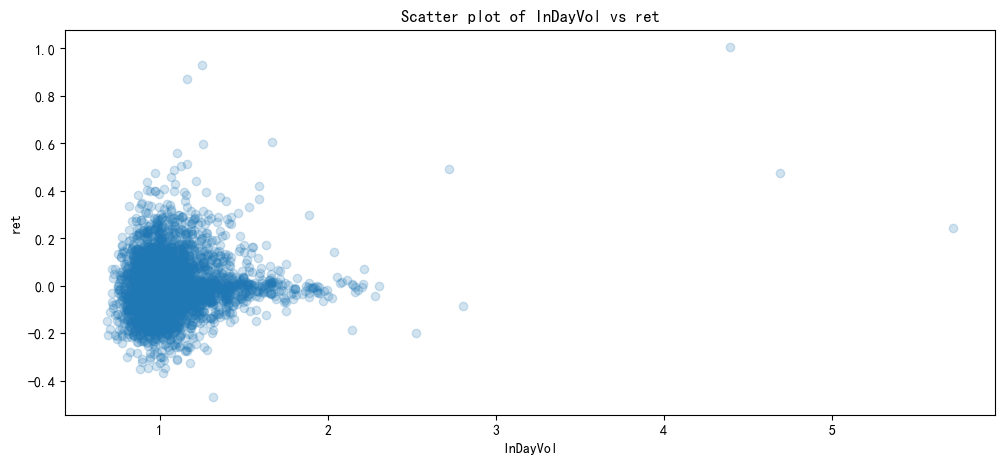

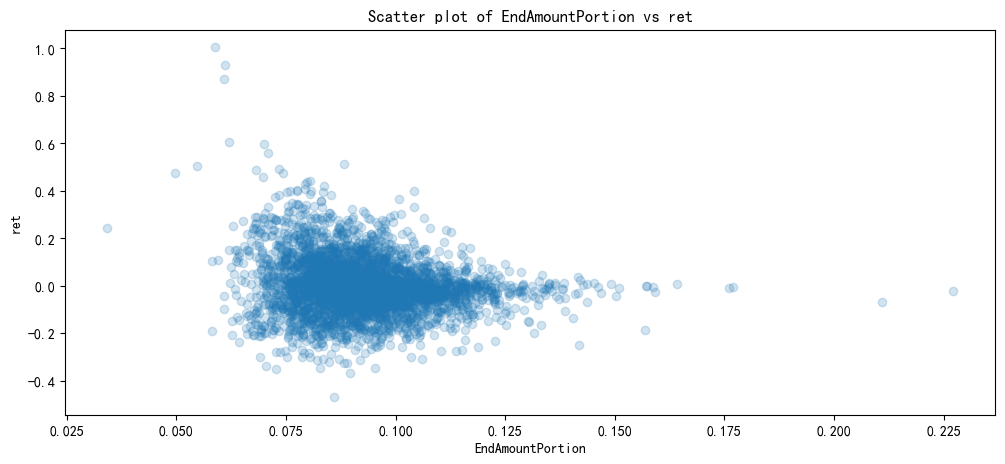

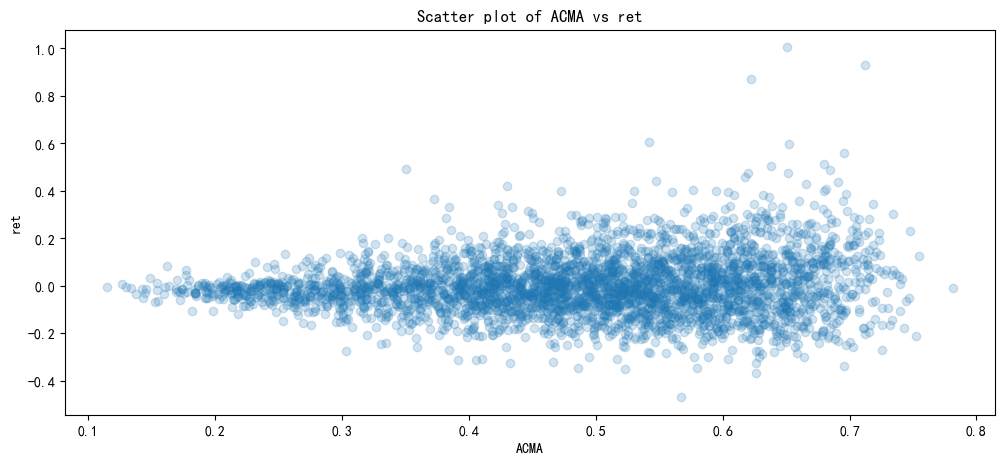

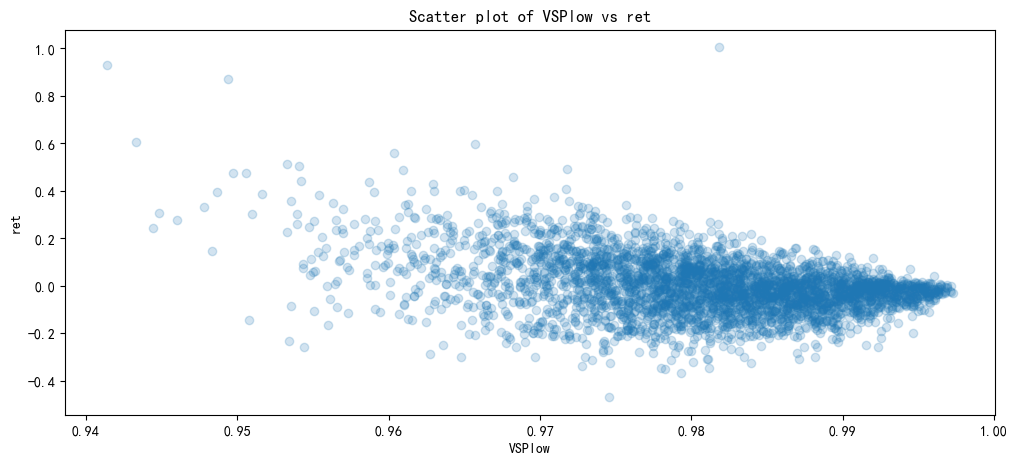

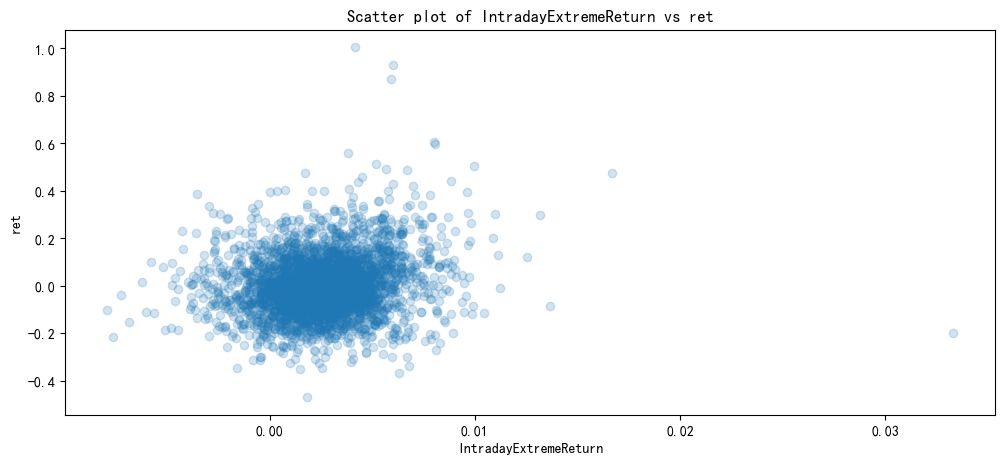

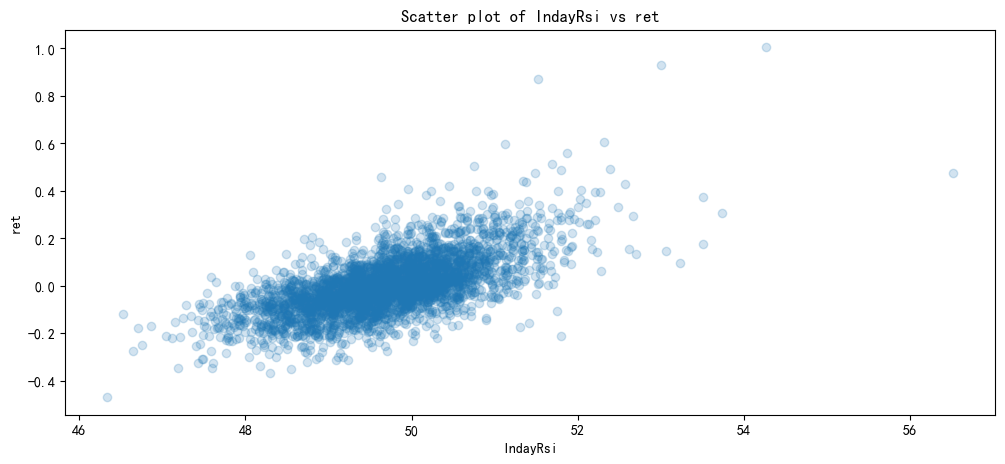

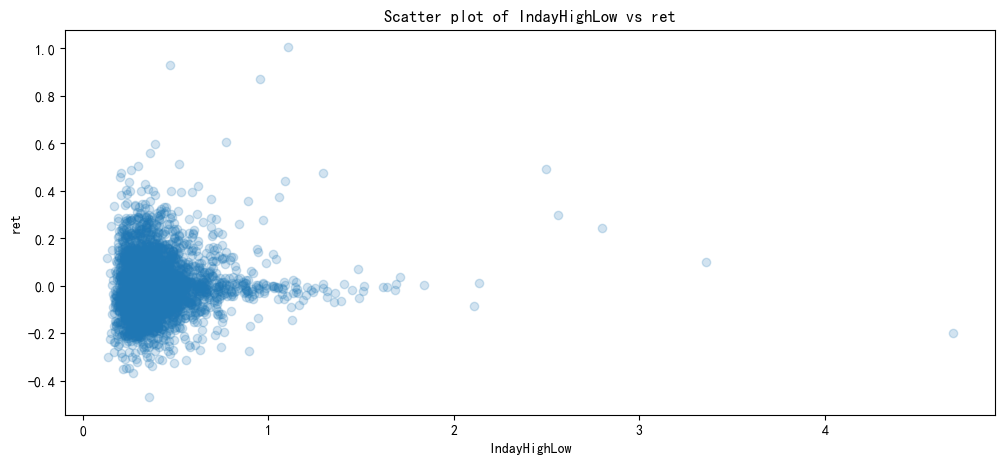

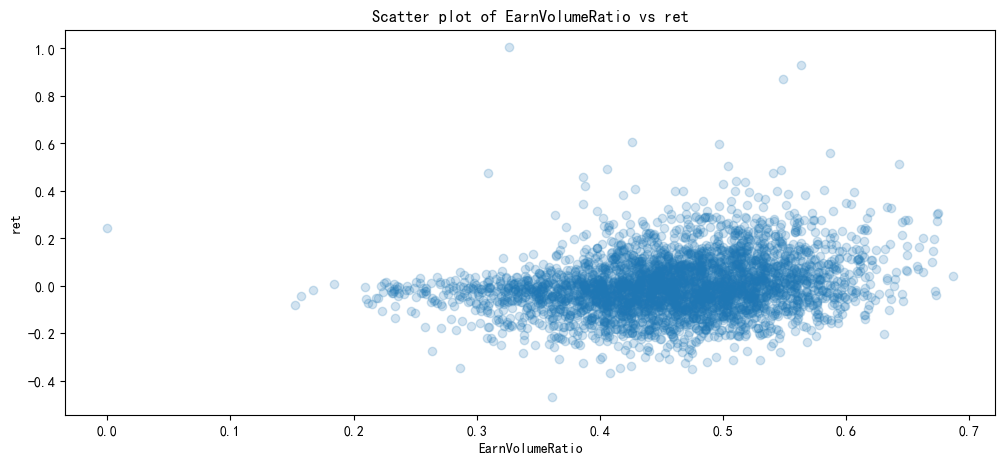

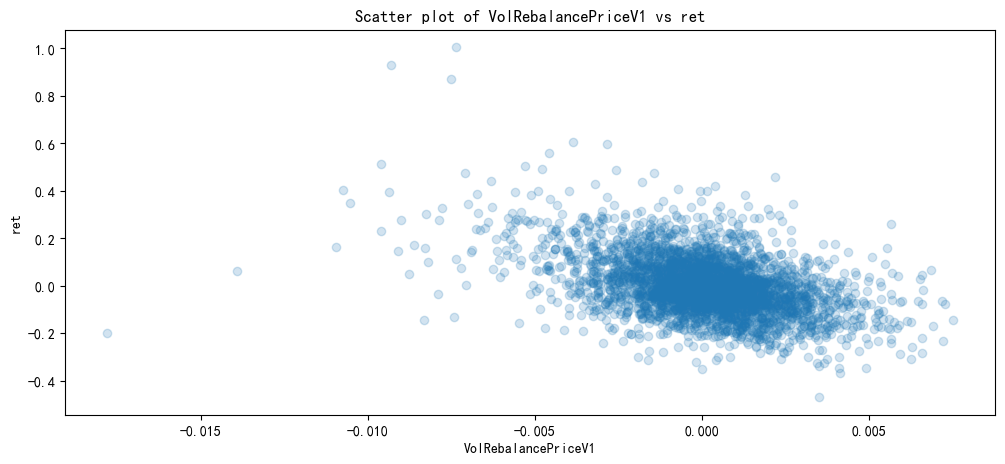

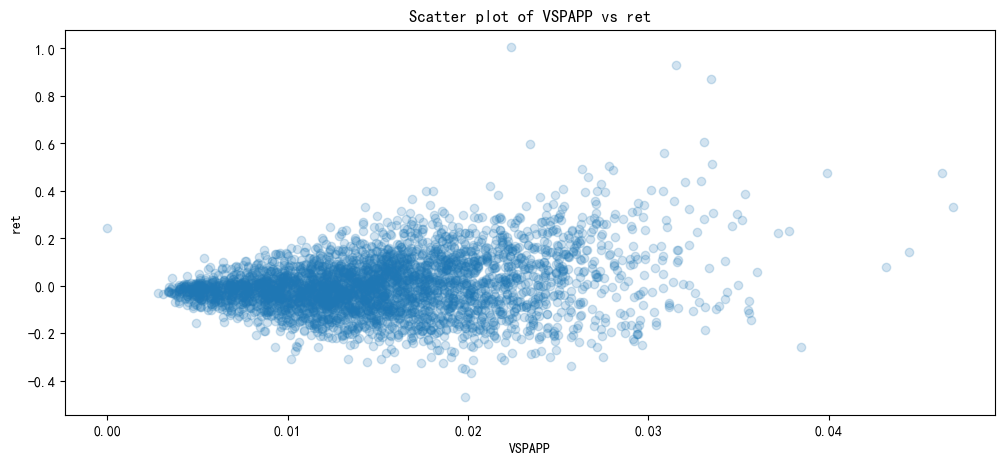

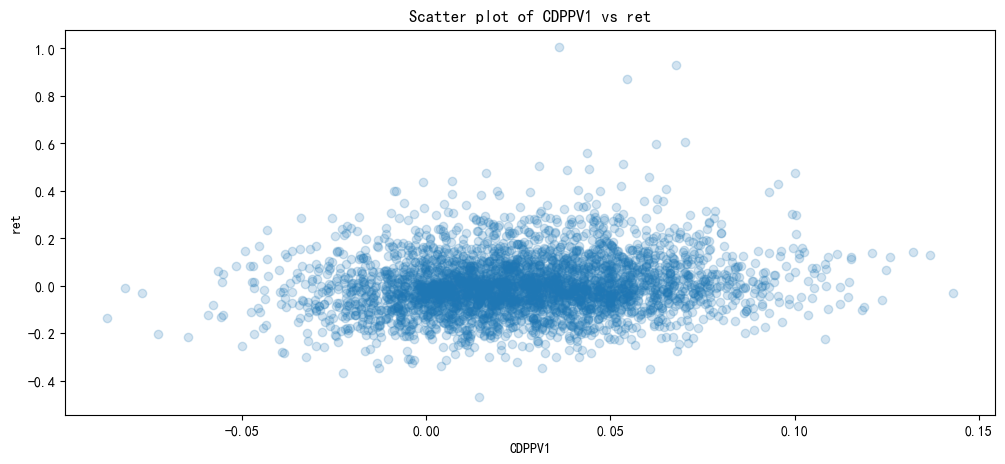

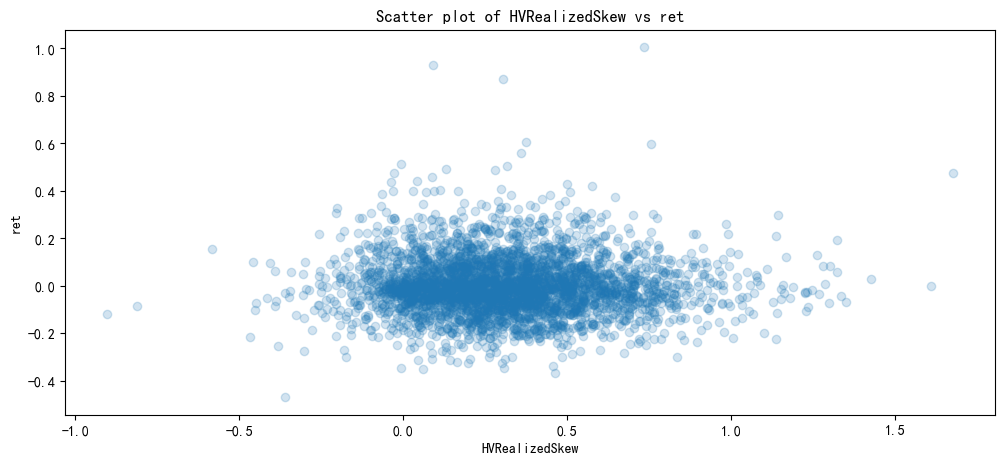

In [ ]:
import matplotlib.pyplot as plt

for col in q_ls:
    if col in df.columns:
        plt.figure(figsize=(12, 5))
        plt.scatter(df[col], df['ret'], alpha=0.2)
        plt.xlabel(col)
        plt.ylabel('ret')
        plt.title(f'Scatter plot of {col} vs ret')
        plt.show()

### Correlation map. Based on the correlation map, we can see the existence of high correlation and corresponding multicollinearity problem.

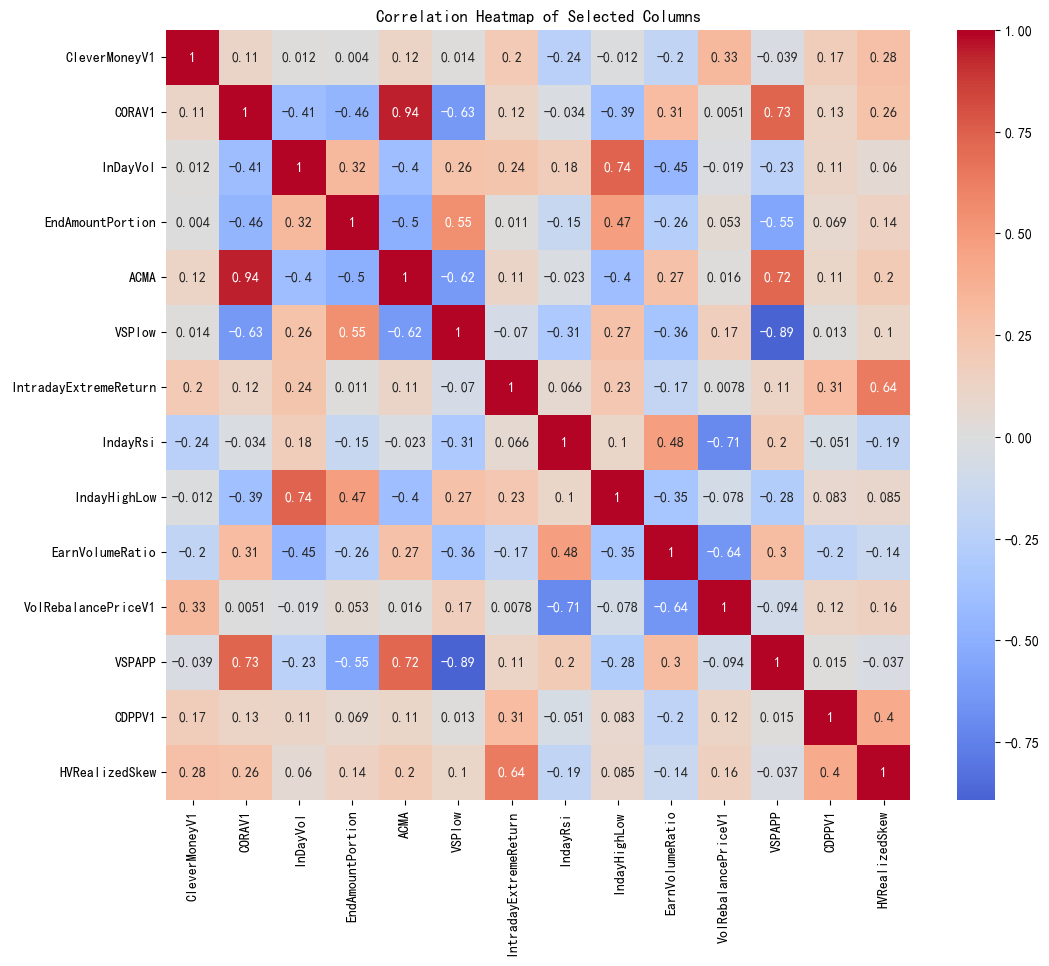

In [ ]:
corr_matrix = df[q_ls].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Selected Columns')
plt.show()

### The distribution of y, which is ret. It generally follows normal distribution

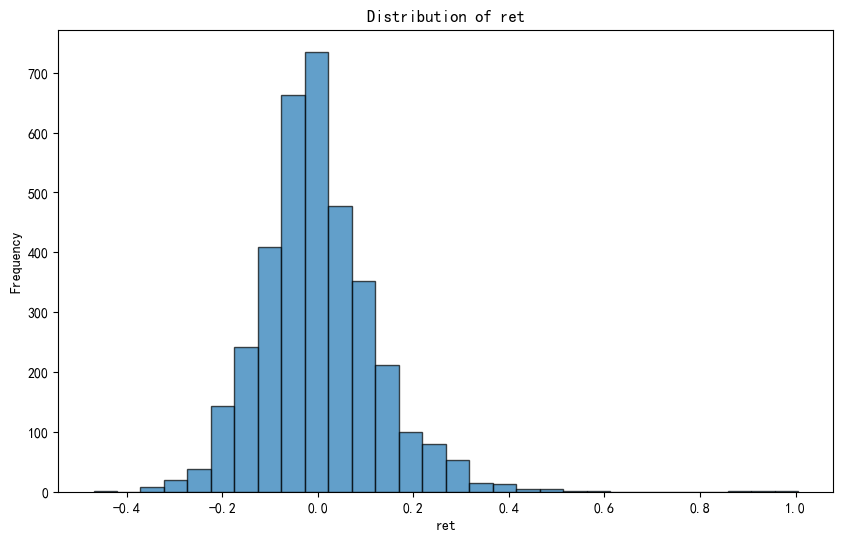

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['ret'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of ret')
plt.xlabel('ret')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df = df.fillna(0)

## Modeling
### Basic model

In [ ]:
df_encoded = pd.get_dummies(df, columns=b_ls, drop_first=True)
X = df_encoded[q_ls + [col for col in df_encoded.columns if any(cat in col for cat in b_ls)]]
y = df_encoded['ret']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     158.5
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:19:47   Log-Likelihood:                 3635.7
No. Observations:                3572   AIC:                            -7227.
Df Residuals:                    3550   BIC:                            -7091.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Model change 1: deleted some variable with no significant contribution to the regression. (with high p-value)
### ACMA, IntradayExtremeReturn, IndayHighLow, HVRealizedSkew, MorningAfternoonVolatilityIndicator_1, MarketCapIndicator_2, MarketCapIndicator_3
### Result: only reduce R-square by 0.003, meaning the reduction of the variables does not affect the effect of the model

In [ ]:
q2_ls = ['CleverMoneyV1', 'CORAV1', 'InDayVol', 'EndAmountPortion', 'VSPlow', 'IndayRsi', 'EarnVolumeRatio', 'VolRebalancePriceV1', 'VSPAPP', 'CDPPV1']
b2_ls = ['JumpIndicator','LiquidityIndicator','ConsecutiveLimitIndicator']

In [ ]:
df_encoded = pd.get_dummies(df, columns=b2_ls, drop_first=True)
X = df_encoded[q2_ls + [col for col in df_encoded.columns if any(cat in col for cat in b2_ls)]]
y = df_encoded['ret']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     235.3
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:20:24   Log-Likelihood:                 3625.0
No. Observations:                3572   AIC:                            -7220.
Df Residuals:                    3557   BIC:                            -7127.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Model change 2: Add three variables
### InDayVol_log, EndAmountPortion_log, IndayRsi_squ
### Computation method is in below code block
### For the logic of transformation, see the scatter plot and corresponding explanation. When doing explanation, can put the scatter plot here to explain why we do the processing.

In [ ]:
df['InDayVol_log'] = np.log(1+df['InDayVol'])
df['EndAmountPortion_log'] =  np.log(1+df['EndAmountPortion'])
df['IndayRsi_squ'] = df['IndayRsi']**2

In [ ]:
q3_ls = ['InDayVol_log','EndAmountPortion_log','CleverMoneyV1',  'IndayRsi_squ', 'CORAV1',  'VSPlow', 'IndayRsi', 'EarnVolumeRatio', 'VolRebalancePriceV1', 'VSPAPP', 'CDPPV1']
b3_ls = ['LiquidityIndicator','JumpIndicator','ConsecutiveLimitIndicator']

### Result: increase R-square from 0.481 to 0.530. Very high improvement

In [ ]:
df_encoded = pd.get_dummies(df, columns=b3_ls, drop_first=True)
X = df_encoded[q3_ls + [col for col in df_encoded.columns if any(cat in col for cat in b3_ls)]]
y = df_encoded['ret']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     267.8
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:20:27   Log-Likelihood:                 3804.4
No. Observations:                3572   AIC:                            -7577.
Df Residuals:                    3556   BIC:                            -7478.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Model change 3: increase some other variables
### ACMA_log, VolRebalancePriceV1_squ
### Computational method as follows
### similar logic as model change 2, but the shape of the scatter plot does not greatly resemble log function and square function, which may be the reason of poor performance

In [ ]:
df['ACMA_log'] = np.log(df['ACMA']+1)
df['VolRebalancePriceV1_squ'] =  df['VolRebalancePriceV1']**3

In [ ]:
q4_ls = ['ACMA_log', 'VolRebalancePriceV1_squ', 'InDayVol_log','EndAmountPortion_log', 'CleverMoneyV1',  'IndayRsi_squ', 'CORAV1',  'VSPlow', 'IndayRsi', 'EarnVolumeRatio', 'VolRebalancePriceV1', 'VSPAPP', 'CDPPV1']
b4_ls = ['LiquidityIndicator','JumpIndicator','ConsecutiveLimitIndicator']

### Result: increase R-square from 0.530 to 0.532, little improvements

In [ ]:
df_encoded = pd.get_dummies(df, columns=b4_ls, drop_first=True)
X = df_encoded[q4_ls + [col for col in df_encoded.columns if any(cat in col for cat in b4_ls)]]
y = df_encoded['ret']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     237.6
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:20:31   Log-Likelihood:                 3810.4
No. Observations:                3572   AIC:                            -7585.
Df Residuals:                    3554   BIC:                            -7473.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Model change 4: add month quanlitative variables(as mentioned by professor)
### Month qualitative variable: dummy variables. We have 11 variables indicating month 2 to month 12. If the variable of certain month is 1, it represents that month. If all 0, then represents month1.
### Result: increase R-square from 0.532 to 0.560, big improvement!

In [ ]:
q5_ls = ['ACMA_log', 'VolRebalancePriceV1_squ', 'InDayVol_log','EndAmountPortion_log', 'CleverMoneyV1',  'IndayRsi_squ', 'CORAV1',  'VSPlow', 'IndayRsi', 'EarnVolumeRatio', 'VolRebalancePriceV1', 'VSPAPP', 'CDPPV1']
b5_ls = ['LiquidityIndicator','JumpIndicator','ConsecutiveLimitIndicator', 'month_factor']

In [ ]:
df_encoded = pd.get_dummies(df, columns=b5_ls, drop_first=True)
X = df_encoded[q5_ls + [col for col in df_encoded.columns if any(cat in col for cat in b5_ls)]]
y = df_encoded['ret']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     160.8
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:20:34   Log-Likelihood:                 3919.4
No. Observations:                3572   AIC:                            -7781.
Df Residuals:                    3543   BIC:                            -7602.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Model adjustments: Handeling Multicollinearity
## Using VIF to deal with multicollinearity

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import statsmodels.api as sm


df_encoded = pd.get_dummies(df, columns=b5_ls, drop_first=True)
X = df_encoded[q5_ls + [col for col in df_encoded.columns if any(cat in col for cat in b5_ls)]]

X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                        Feature           VIF
0                         const  2.236322e+06
1                      ACMA_log  1.014065e+01
2       VolRebalancePriceV1_squ  1.573089e+00
3                  InDayVol_log  2.401442e+00
4          EndAmountPortion_log  1.776113e+00
5                 CleverMoneyV1  1.300611e+00
6                  IndayRsi_squ  1.008371e+00
7                        CORAV1  1.045809e+01
8                        VSPlow  6.321363e+00
9                      IndayRsi  1.830605e+00
10              EarnVolumeRatio  3.683209e+00
11          VolRebalancePriceV1  4.264131e+00
12                       VSPAPP  8.302695e+00
13                       CDPPV1  1.185976e+00
14            JumpIndicator_ogn  3.298077e+00
15         LiquidityIndicator_1  1.520165e+00
16              JumpIndicator_1  2.825774e+00
17  ConsecutiveLimitIndicator_1  1.670098e+00
18               month_factor_2  1.976893e+00
19               month_factor_3  1.970092e+00
20               month_factor_4  1

## Method: removing variable VSPAPP. You may think of a reason behind it, like based on VIF result and correlation heatmap
## Heatmap: VSPAPP has high correlation of many other variables, removing it can greatly reduce multicollinearity
## Result: No obvious Multicollinearity after deleting VSPAPP

In [ ]:
q6_ls = ['VolRebalancePriceV1_squ', 'InDayVol_log','EndAmountPortion_log', 'CleverMoneyV1',  'IndayRsi_squ', 'CORAV1',  'VSPlow', 'IndayRsi', 'EarnVolumeRatio', 'VolRebalancePriceV1', 'CDPPV1']
b6_ls = ['LiquidityIndicator','JumpIndicator','ConsecutiveLimitIndicator', 'month_factor']

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import statsmodels.api as sm


df_encoded = pd.get_dummies(df, columns=b6_ls, drop_first=True)
X = df_encoded[q6_ls + [col for col in df_encoded.columns if any(cat in col for cat in b6_ls)]]

X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                        Feature           VIF
0                         const  1.988450e+06
1       VolRebalancePriceV1_squ  1.615412e+00
2                  InDayVol_log  2.299526e+00
3          EndAmountPortion_log  1.731196e+00
4                 CleverMoneyV1  1.233649e+00
5                  IndayRsi_squ  2.864153e+01
6                        CORAV1  2.305276e+00
7                        VSPlow  3.375835e+00
8                      IndayRsi  2.328386e+01
9               EarnVolumeRatio  3.616638e+00
10          VolRebalancePriceV1  4.953930e+00
11                       CDPPV1  1.190085e+00
12            JumpIndicator_ogn  3.232333e+00
13         LiquidityIndicator_1  1.803774e+00
14              JumpIndicator_1  2.810311e+00
15  ConsecutiveLimitIndicator_1  1.656734e+00
16               month_factor_2  1.975670e+00
17               month_factor_3  1.969185e+00
18               month_factor_4  1.984942e+00
19               month_factor_5  1.961966e+00
20               month_factor_6  1

## Result of final model: R-square 0.538

In [ ]:
df_encoded = pd.get_dummies(df, columns=b6_ls, drop_first=True)
X = df_encoded[q6_ls + [col for col in df_encoded.columns if any(cat in col for cat in b6_ls)]]
y = df_encoded['ret']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     158.5
Date:                Sat, 23 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:33:01   Log-Likelihood:                 3831.8
No. Observations:                3572   AIC:                            -7610.
Df Residuals:                    3545   BIC:                            -7443.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Testing the distribution of residuals. Use histogram, QQ-plot and Cook's Distance
### For cook's distance result, some points above the red line, a cutoff value which suggests that points above this line might be outliers. But not exceeding the line greatly, so may be normal variations, no need to worry too much

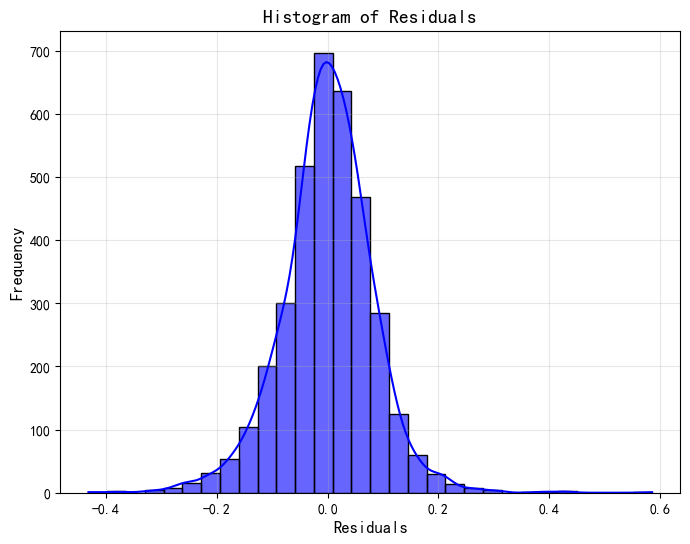

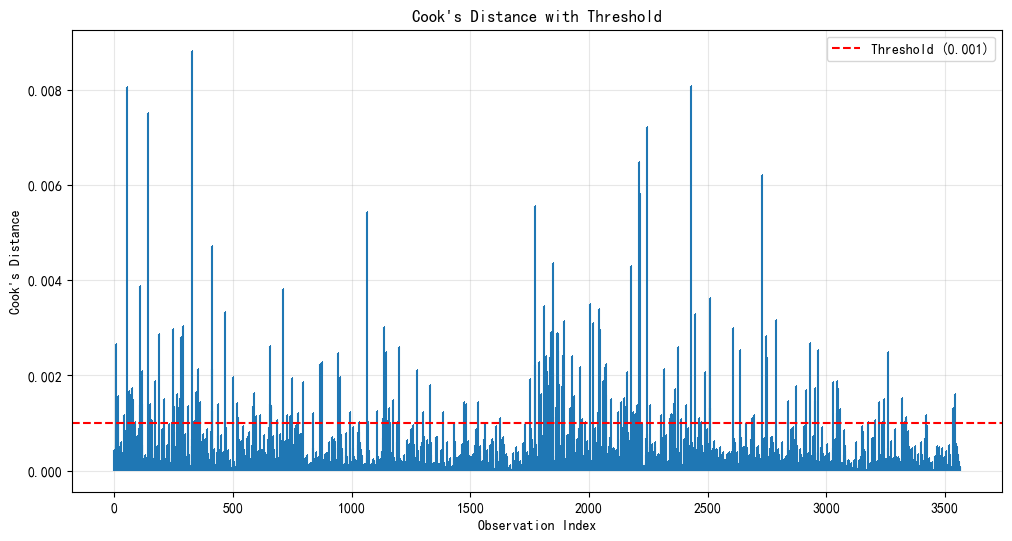

<Figure size 600x600 with 0 Axes>

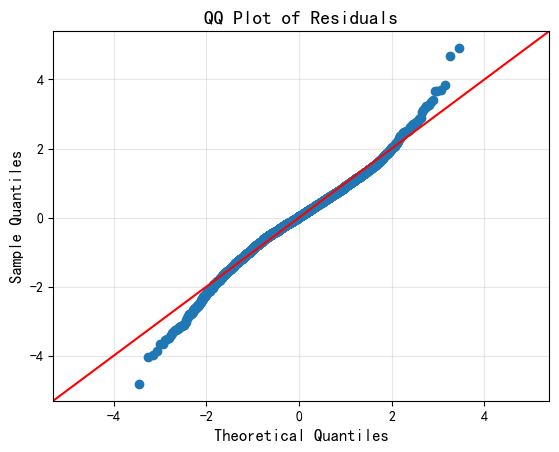

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

residuals = model.resid


plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of Residuals', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
cooks_d

plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ", use_line_collection=True)
plt.axhline(y=0.001, color='red', linestyle='--', label='Threshold (0.001)')
plt.title("Cook's Distance with Threshold")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ Plot of Residuals', fontsize=14)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

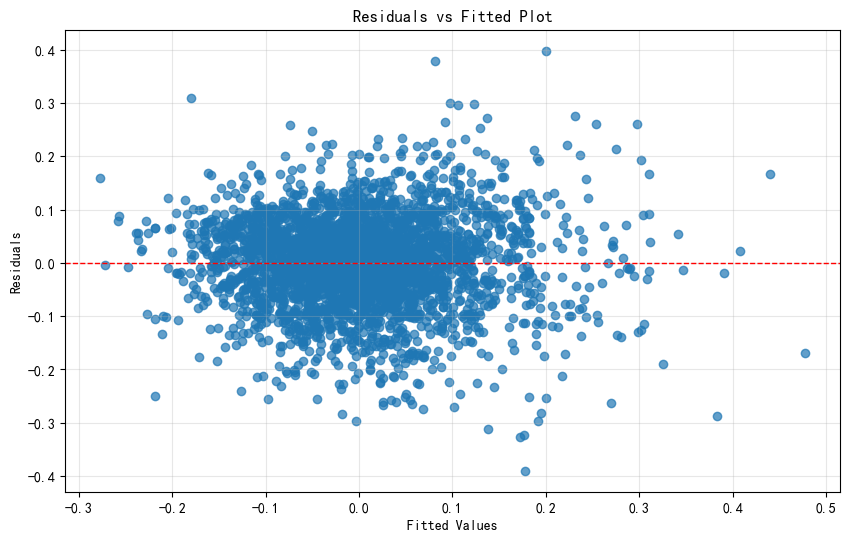

In [ ]:
import statsmodels.api as sm

# Residuals vs. Fitted Plot
fitted_values = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from statsmodels.stats.stattools import durbin_watson
residuals = model.resid
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

Durbin-Watson statistic: 1.9098715018285335
